On va avoir un problème avec la limitation à 512 tokens de BERT...

# Testing

In [1]:
import numpy as np 
import datasets 
import evaluate
from transformers import BertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline

import torch
import json
import pandas as pd
import re

conll2003 = datasets.load_dataset("conll2003", trust_remote_code=True) 

In [2]:
conll2003

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [3]:
conll2003.shape

{'train': (14041, 5), 'validation': (3250, 5), 'test': (3453, 5)}

In [4]:
conll2003["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [5]:
conll2003["train"].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [6]:
conll2003['train'].description

'The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on\nfour types of named entities: persons, locations, organizations and names of miscellaneous entities that do\nnot belong to the previous three groups.\n\nThe CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on\na separate line and there is an empty line after each sentence. The first item on each line is a word, the second\na part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags\nand the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only\nif two phrases of the same type immediately follow each other, the first word of the second phrase will have tag\nB-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2\ntagging scheme, whereas the original dataset uses 

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased") 

In [8]:
example_text = conll2003['train'][0]

tokenized_input = tokenizer(example_text["tokens"], is_split_into_words=True)

tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

word_ids = tokenized_input.word_ids()

print(word_ids)

tokenized_input

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]


{'input_ids': [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
#101 [CLS] #102 [SEP]

In [10]:
len(example_text['ner_tags']), len(tokenized_input["input_ids"])
#which causes to add more input ids than tags as no tag where assigned to these two in the tokenization phase!
#moreover, berttokenizer tokenizes into subwords so we can get further differences

(9, 11)

In [11]:
#so we need to define a function to align tokens and labels properly:
#1 - deal with CLS/SEP tokens
#2 - duplicate tags for subwords tokens

def tokenize_and_align_labels(examples, label_all_tokens=True): 
    """
    Looping over tokens and tags to align them. Set to be ignored tokens to -100 (considered as padding). 
    """
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None 
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are originally mapped to None 
        # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token                 
                label_ids.append(label[word_idx]) 
            else: 
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                # mask the subword representations after the first subword
                 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

In [12]:
test = tokenize_and_align_labels(conll2003['train'][1:2])
print(test)

{'input_ids': [[101, 2848, 13934, 102]], 'token_type_ids': [[0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1]], 'labels': [[-100, 1, 2, -100]]}


In [13]:
# tokenizer.convert_ids_to_tokens(test["input_ids"][0])
for token, label in zip(tokenizer.convert_ids_to_tokens(test["input_ids"][0]),test["labels"][0]): 
    print(f"{token:_<20} {label}") 

[CLS]_______________ -100
peter_______________ 1
blackburn___________ 2
[SEP]_______________ -100


In [14]:
#ok it works, now lets apply it to the whole dataset
tokenized_dataset = conll2003.map(tokenize_and_align_labels, batched=True) #batched for train/test/eval

In [15]:
model = AutoModelForTokenClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=9) #as defined by the dataset #deberta might be a good choice too

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
args = TrainingArguments(
    "../models/", 
    eval_strategy="epoch", 
    learning_rate=2e-5,
    per_device_train_batch_size=16, 
    per_gpu_eval_batch_size=16,
    num_train_epochs=2,  
    weight_decay=0.01
)

In [17]:
torch.cuda.get_device_name(0)
#this will limit the model size. Even BERT large takes ages to fine tune...

'NVIDIA GeForce GTX 1080'

In [18]:
#batching + padding
data_collator = DataCollatorForTokenClassification(tokenizer)

In [19]:
metrics = evaluate.load("seqeval")

In [20]:
#get the tag classes
label_list = conll2003["train"].features["ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

## Example

In [21]:
example = conll2003['train'][0]

In [22]:
labels = [label_list[i] for i in example["ner_tags"]] #maps id to class name
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [23]:
example_eval = metrics.compute(predictions=[labels], references=[labels])
for x in example_eval :
    print(x, example_eval[x])
#eval against same set so 1 is expected

MISC {'precision': np.float64(1.0), 'recall': np.float64(1.0), 'f1': np.float64(1.0), 'number': np.int64(2)}
ORG {'precision': np.float64(1.0), 'recall': np.float64(1.0), 'f1': np.float64(1.0), 'number': np.int64(1)}
overall_precision 1.0
overall_recall 1.0
overall_f1 1.0
overall_accuracy 1.0


## Compute Metrics

In [24]:
def compute_metrics(eval_preds): 
    """Returns:
    A dictionary containing the precision, recall, F1 score and accuracy.
    """
    pred_logits, labels = eval_preds 
    
    pred_logits = np.argmax(pred_logits, axis=2) 
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax
    
    # We remove all the values where the label is -100
    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metrics.compute(predictions=predictions, references=true_labels) 
    return { 
   "precision": results["overall_precision"], 
   "recall": results["overall_recall"], 
   "f1": results["overall_f1"], 
  "accuracy": results["overall_accuracy"], 
  } 

## Training

In [25]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [26]:
trainer.train()

model.save_pretrained("../models/ner_model")
tokenizer.save_pretrained("../models/tokenizer")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.221900,0.065405,0.914516,0.927509,0.920966,0.982064
2,0.046300,0.060432,0.925779,0.937689,0.931696,0.984034


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


('../models/tokenizer\\tokenizer_config.json',
 '../models/tokenizer\\special_tokens_map.json',
 '../models/tokenizer\\vocab.txt',
 '../models/tokenizer\\added_tokens.json',
 '../models/tokenizer\\tokenizer.json')

In [27]:
id2label = {str(i) : label for i, label in enumerate(label_list)}
label2id = {label : str(i) for i, label in enumerate(label_list)}

## Load fine-tuned model

In [28]:
config = json.load(open("../models/ner_model/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("../models/ner_model/config.json","w"))
fine_tuned_model = AutoModelForTokenClassification.from_pretrained("../models/ner_model")

In [29]:
nlp = pipeline("ner", model=fine_tuned_model, tokenizer=tokenizer, aggregation_strategy="SIMPLE") #a banger of an option

Device set to use cuda:0


In [30]:
example = "This Chevrolet Colorado was owned by Barack Obama."

ner_results = nlp(example)
for x in ner_results:
    print(x)

{'entity_group': 'MISC', 'score': np.float32(0.9426583), 'word': 'chevrolet colorado', 'start': 5, 'end': 23}
{'entity_group': 'PER', 'score': np.float32(0.9819981), 'word': 'barack obama', 'start': 37, 'end': 49}


## Load dataframe

In [3]:
import pandas as pd
main_df = pd.read_csv("../data/cleaned_data.csv") 
df_filtered = main_df[(main_df['price'] > 500) & (main_df['price'] <= 500000) &  (main_df['odometer'] <= 500000) & (main_df['year'] >= 1980)].copy()

In [4]:
descriptions = df_filtered.description
print(f"{len(descriptions)} descriptions available")

343285 descriptions available


In [5]:
#it's a bit too much for now. Let's just take 1000 to start

descriptions = descriptions[:1000]
descriptions = descriptions.tolist()

Token indices sequence length is longer than the specified maximum sequence length for this model (1153 > 512). Running this sequence through the model will result in indexing errors


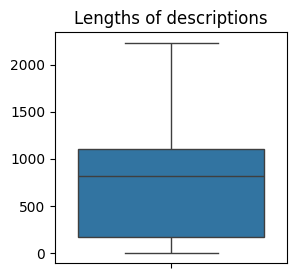

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

a = tokenizer(descriptions)
lengths = [len(x) for x in a["input_ids"]]

plt.figure(figsize=(3, 3))
sns.boxplot(data=lengths)
plt.title('Lengths of descriptions')
plt.show()

It seems that we are above the 512 tokens limitation of BERT. The model should cut after 512 tokens automatically, let's see.

In [6]:
import random
example = random.choice(descriptions)

example = descriptions[970]

print(f"{len(tokenizer(example)["input_ids"])} tokens in the sequence: {example}")

ner_results = nlp(example)
for x in ner_results:
    if x["score"] > 0.85 :
            print(x)

NameError: name 'tokenizer' is not defined

## GliNER

In [1]:
#no need to fine-tune if someone already built a very capable model:

from gliner import GLiNER

model = GLiNER.from_pretrained("urchade/gliner_large-v2")

text = """
Cristiano Ronaldo dos Santos Aveiro (Portuguese pronunciation: [kɾiʃˈtjɐnu ʁɔˈnaldu]; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for and captains both Saudi Pro League club Al Nassr and the Portugal national team. Widely regarded as one of the greatest players of all time, Ronaldo has won five Ballon d'Or awards,[note 3] a record three UEFA Men's Player of the Year Awards, and four European Golden Shoes, the most by a European player. He has won 33 trophies in his career, including seven league titles, five UEFA Champions Leagues, the UEFA European Championship and the UEFA Nations League. Ronaldo holds the records for most appearances (183), goals (140) and assists (42) in the Champions League, goals in the European Championship (14), international goals (128) and international appearances (205). He is one of the few players to have made over 1,200 professional career appearances, the most by an outfield player, and has scored over 850 official senior career goals for club and country, making him the top goalscorer of all time.
"""

labels = ["person", "award", "date", "competitions", "teams"]

entities = model.predict_entities(text, labels)

for entity in entities:
    print(entity["text"], "=>", entity["label"])


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\thebo\Desktop\AutoNLP\venv_project\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Cristiano Ronaldo dos Santos Aveiro => person
5 February 1985 => date
Ballon d'Or => award
UEFA Men's Player of the Year Awards => award
European Golden Shoes => award
UEFA Champions Leagues => competitions
UEFA Nations League => competitions


In [12]:
labels = ["model", "brand", "vehicle", "color"]

entities = model.predict_entities(descriptions[970], labels)

print(descriptions[970])

for entity in entities:
    print(entity["text"], "=>", entity["label"])

2012 Chevrolet Express Commercial Cutaway 3500, 12 FOOT ENCLOSED UTILITY BODY,, 108K - $26,990  Year: 2012 Make:Chevrolet Model:Express Commercial Cutaway Trim:3500, 12 FOOT ENCLOSED UTILITY BODY,, 108K Mileage:108,439 Stock #:VM14021 VIN:1GB0G2BA6C1158438 Trans:Automatic Color:White Vehicle Type:Service Body State:NJ Drive Train:RWD Engine:Engine, Vortec 4.8L V8 SFI (280 hp [208.8 kW] @ 5200 rpm, 295 lb-ft of torque [398.3 N-m] @ 4600 rpm) (Standard on the CG33503 and CG33803 models. With CG33503 requires (C4M) 9900 lbs. (4490 kg) GVWR or (C7A) 10,000 lbs. (4536 kg) GVWR. With CG33803 model  Notes ,,,.keywords, fence truck, fence company truck, stake body, trucks for sale near me , pick up truck for sale near me , rack truck , rack body , utility body , work trucks , liftgate , lift gate truck , work trucks for sale , flat deck , dump truck, roll back, commercial trucks, bucket truck, f150 f 150 f-150 , f250 f 250 f-250 , f350 f 350 f-350 , f450 f 450 f-450 , f550 f 550 f-550, f650 , 